#### Import necessary libraries

In [75]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as skl
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

from reparo import CDI, FRNNI, HotDeckImputation, KNNImputer, PMM, SICE, MICE

#### Analyses of given DataSet

In [2]:
dataFrame = pd.read_csv('HousingData.csv')
dataFrame.info()
missing_values = dataFrame.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


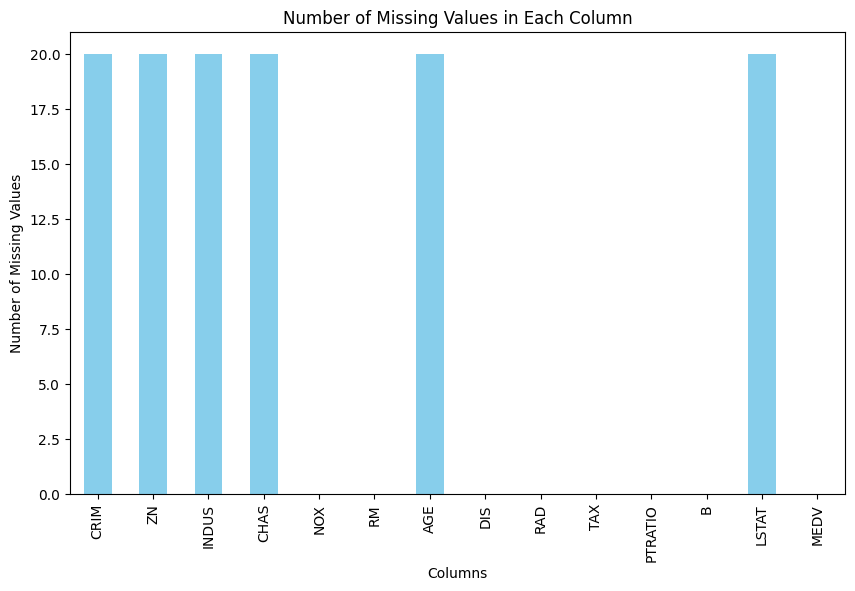

In [3]:
missing_values.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Number of Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.show()

In [4]:
dataFrame

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,NaN,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [5]:
dataFrame.describe().transpose().applymap(lambda x: format(x, '.3f'))

,count,mean,std,min,25%,50%,75%,max
CRIM,486.000,3.612,8.720,0.006,0.082,0.254,3.560,88.976
ZN,486.000,11.212,23.389,0.000,0.000,0.000,12.500,100.000
INDUS,486.000,11.084,6.836,0.460,5.190,9.690,18.100,27.740
CHAS,486.000,0.070,0.255,0.000,0.000,0.000,0.000,1.000
NOX,506.000,0.555,0.116,0.385,0.449,0.538,0.624,0.871
RM,506.000,6.285,0.703,3.561,5.885,6.208,6.623,8.780
AGE,486.000,68.519,28.000,2.900,45.175,76.800,93.975,100.000
DIS,506.000,3.795,2.106,1.130,2.100,3.207,5.188,12.127
RAD,506.000,9.549,8.707,1.000,4.000,5.000,24.000,24.000
TAX,506.000,408.237,168.537,187.000,279.000,330.000,666.000,711.000


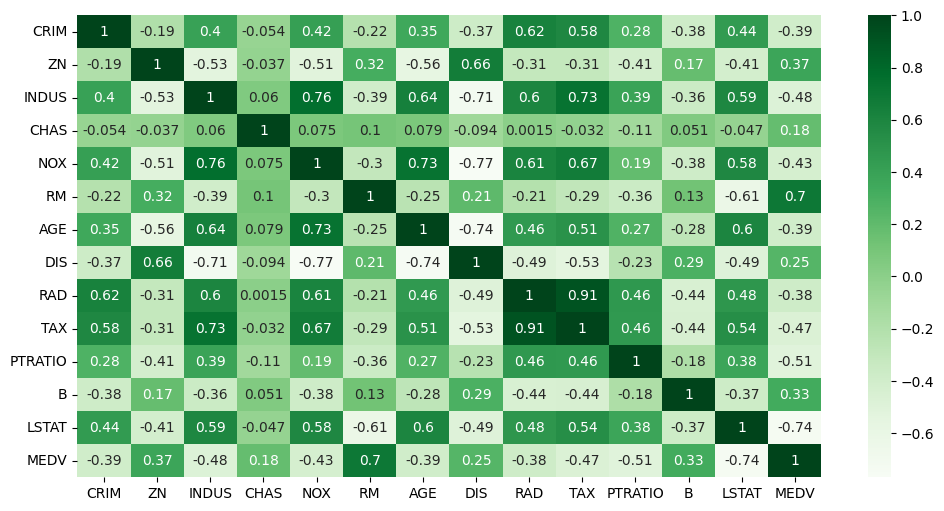

In [6]:
plt.figure(figsize=(12, 6))
sns.heatmap(dataFrame.corr(), annot=True, cmap='Greens')
plt.show()

In [55]:
target_df = dataFrame[['RM', 'LSTAT', 'PTRATIO', 'INDUS', 'TAX']]
target = dataFrame['MEDV']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(target_df, target, test_size=0.2, random_state=42)

In [56]:
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
constant_imputer = SimpleImputer(strategy='constant', fill_value=0)

In [57]:
# Create instances of imputation algorithms
cdi_imputer = CDI()
frnni_imputer = FRNNI()
hotdeck_imputer = HotDeckImputation()
knn_imputer = KNNImputer()
pmm_imputer = PMM()
sice_imputer = SICE()
mice_imputer = MICE()

# List of imputers
imputers = [cdi_imputer, frnni_imputer, hotdeck_imputer, knn_imputer, pmm_imputer, sice_imputer, mice_imputer,
            mean_imputer, median_imputer, most_frequent_imputer, constant_imputer]

In [105]:
# List of prediction algorithms
models = [
    # LogisticRegression(),
    # GaussianNB(),
    DecisionTreeRegressor(),
    RandomForestRegressor()
]

results_table_regression = pd.DataFrame(columns=['Imputation Algorithm', 'Prediction Algorithm', 'MSE'])

In [106]:
for imputer in imputers:
    # Impute missing values on the training set
    X_train_imputed = imputer.fit_transform(X_train.values)

    # Impute missing values on the test set
    X_test_imputed = imputer.transform(X_test.values)

    # Iterate over each model
    for model in models:
        # Train the model on the imputed training set
        model.fit(X_train_imputed, y_train)

        # Make predictions on the imputed test set
        predictions = model.predict(X_test_imputed)

        # Calculate accuracy and store the results in the table
        # accuracy = accuracy_score(y_test, predictions)
        # results_table = results_table.append({
        #     'Imputation Algorithm': type(imputer).__name__,
        #     'Prediction Algorithm': type(model).__name__,
        #     'Accuracy': accuracy
        # }, ignore_index=True)

        mse = mean_squared_error(y_test, predictions)
        result_row = {
            'Imputation Algorithm': type(imputer).__name__,
            'Prediction Algorithm': type(model).__name__,
            'MSE': mean_squared_error(y_test, predictions)
        }
        results_table_regression = pd.concat([results_table_regression, pd.DataFrame([result_row])], ignore_index=True)

# Display the results table
print(results_table_regression)

   Imputation Algorithm   Prediction Algorithm        MSE
0                   CDI  DecisionTreeRegressor  28.496765
1                   CDI  RandomForestRegressor  15.515460
2                 FRNNI  DecisionTreeRegressor  18.725686
3                 FRNNI  RandomForestRegressor  14.290803
4     HotDeckImputation  DecisionTreeRegressor  21.953333
5     HotDeckImputation  RandomForestRegressor  15.387198
6            KNNImputer  DecisionTreeRegressor  15.853922
7            KNNImputer  RandomForestRegressor  14.774136
8                   PMM  DecisionTreeRegressor  44.799020
9                   PMM  RandomForestRegressor  17.482265
10                 SICE  DecisionTreeRegressor  17.248333
11                 SICE  RandomForestRegressor  15.732200
12                 MICE  DecisionTreeRegressor  30.339118
13                 MICE  RandomForestRegressor  13.699788
14        SimpleImputer  DecisionTreeRegressor  29.858235
15        SimpleImputer  RandomForestRegressor  14.314138
16        Simp

Из результатов можно заметить что лучше всего справился с задачей SimpleImputer с strategy='median'. Из этого можно сделать вывод что среднее значение в данном датасете подходит для описания многих других значений параметров 